# Dimensionality Reduction Example

Using the IMDB data, feature matrix and apply dimensionality reduction to this matrix via PCA and SVD.

In [4]:
%matplotlib inline

In [5]:
import json
import random
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from scipy.sparse import lil_matrix

from sklearn.neighbors import DistanceMetric

from sklearn.metrics import jaccard_score
from sklearn.metrics import pairwise_distances

In [7]:
# For testing, set abridge to true and a small dataset limit
#. Can run with MinHash without abridging your data
abridge = True
dataset_limit = 10000

In [8]:
actor_id_to_name_map = {}     # Map Actor IDs to actor names
actor_id_to_index_map = {}    # Map actor IDs to a unique index of known actors
index_to_actor_ids = []       # Array mapping unique index back to actor ID (invert of actor_id_to_index_map)

index_counter = 0    # Unique actor index; increment for each new actor
known_actors = set()

movie_actor_map = {} # dict of all our movies and their actors

test_count = 0
with open("../data/imdb_movies_2000to2022.prolific.json", "r") as in_file:
    for line in in_file:
        
        this_movie = json.loads(line)

        # Keep track of all the actors in this movie            
        for actor_id,actor_name in this_movie['actors']:
            
            # Keep names and IDs
            actor_id_to_name_map[actor_id] = actor_name
            
            # If we've seen this actor before, skip...
            if actor_id in known_actors:
                continue
                
            # ... Otherwise, add to known actor set and create new index for them
            known_actors.add(actor_id)
            actor_id_to_index_map[actor_id] = index_counter
            index_to_actor_ids.append(actor_id)
            index_counter += 1
            

        # Finished with this film
        movie_actor_map[this_movie["imdb_id"]] = ({
            "movie": this_movie["title"],
            "actors": {a[0] for a in this_movie['actors']},
            "genres": this_movie["genres"]
        })
        
        # If abrdiged, test for limit
        test_count += 1        
        if abridge and test_count > dataset_limit:
            break

In [9]:
print("Known Actors:", len(known_actors))

Known Actors: 18324


## Generate Same DataFrame using Sparse Matrics

The above will break if you have too much data. We can get around that partially with sparse matrices, where we only store the non-zero elements of the feature matrix and their indices.

In [13]:
# With sparse matrix, initialize to size of Movies x Actors of 0s
matrix_sparse = lil_matrix((len(movie_actor_map), len(known_actors)), dtype=bool)

# Update the matrix, movie by movie, setting non-zero values for the appropriate actors
for row,movie in enumerate(movie_actor_map.values()):   
    for actor_id in movie["actors"]:
        this_index = actor_id_to_index_map[actor_id]
        matrix_sparse[row,this_index] = 1

In [14]:
df = pd.DataFrame.sparse.from_spmatrix(
    matrix_sparse, 
    index=[m["movie"] for m in movie_actor_map.values()],
    columns=[index_to_actor_ids[i] for i in range(len(known_actors))]
)
df

,nm0000212,nm0413168,nm0000630,nm0005227,nm0864851,nm0828288,nm0933983,nm0329491,nm0000417,nm0000603,...,nm0741429,nm10536928,nm10781212,nm7970787,nm8971375,nm6344180,nm0344038,nm3453345,nm0916370,nm0943160
Kate & Leopold,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
The Naked Monster,0,0,0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Crime and Punishment,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
For the Cause,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gang,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
H20: Tremont's Deathmatch Tournament,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
Daydream Nation,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
American Boy,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,0,0,0,0
Big Fat Gypsy Gangster,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,0


In [15]:
top_k_actors = 1000

In [16]:
# Extract the most frequent actors, so we can deal with a reasonable dataset size
actor_df = df.sum(axis=0)
top_actors = set(actor_df.sort_values().tail(top_k_actors).index)

In [17]:
# Restrict the data frame to just the movies containing
#. the top k actors
reduced_df = df[top_actors] # restrict to just these top actors

# throw away movies that don't have any of these actors
reduced_df = reduced_df.loc[reduced_df.sum(axis=1) > 0] 

reduced_df

/var/folders/mp/vvfc5fm144gbdmd1zlp_9l9r0000gn/T/ipykernel_91128/213156259.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  reduced_df = df[top_actors] # restrict to just these top actors


,nm0089217,nm0001458,nm0001099,nm0611552,nm1725848,nm3859710,nm0687625,nm0442207,nm0000194,nm0000201,...,nm0583951,nm0335300,nm0005162,nm0004193,nm0322407,nm0052410,nm0992000,nm3873544,nm1102465,nm0051509
Kate & Leopold,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
The Naked Monster,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Crime and Punishment,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
For the Cause,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Remembering Mario,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Monster,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FMW-E/H20: Destiny,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
H20: Tremont's Deathmatch Tournament,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Daydream Nation,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Apply PCA to Feature Matrix

In [18]:
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
from sklearn.decomposition import PCA 

In [19]:
matrix_dense = reduced_df.to_numpy()
reduced_df

,nm0089217,nm0001458,nm0001099,nm0611552,nm1725848,nm3859710,nm0687625,nm0442207,nm0000194,nm0000201,...,nm0583951,nm0335300,nm0005162,nm0004193,nm0322407,nm0052410,nm0992000,nm3873544,nm1102465,nm0051509
Kate & Leopold,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
The Naked Monster,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Crime and Punishment,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
For the Cause,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Remembering Mario,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Monster,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FMW-E/H20: Destiny,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
H20: Tremont's Deathmatch Tournament,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Daydream Nation,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
pca = PCA(n_components=2)

In [21]:
pca.fit(matrix_dense)

PCA(n_components=2)

In [22]:
matrix_reduced = pca.transform(matrix_dense)

In [23]:
np.mean(matrix_reduced, axis=0)

array([-3.80018365e-18, -1.53087507e-17])

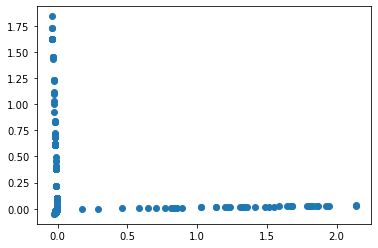

In [24]:
plt.scatter(matrix_reduced[:,0], matrix_reduced[:,1])

In [32]:
comp1_genre_map = {}
comp1_actor_map = {}

comp1_counter = 0
for index in np.argwhere((matrix_reduced[:,0] > 1.0) & (matrix_reduced[:,1] < 0.2)):
    movie_title = reduced_df.index[index[0]]
    for this_movie in [m for m in movie_actor_map.values() if m['movie'] == movie_title]:
        for g in this_movie["genres"]:
            comp1_genre_map[g] = comp1_genre_map.get(g, 0) + 1
        for a in [actor_id_to_name_map[actor] for actor in this_movie["actors"]]:
            comp1_actor_map[a] = comp1_actor_map.get(a, 0) + 1

    comp1_counter += 1
    
print("Movies in Component 1:", comp1_counter)

print("Genres:")
for g in sorted(comp1_genre_map, key=comp1_genre_map.get, reverse=True)[:10]:
    print("\t", g, comp1_genre_map[g])
print("Actors:")
for a in sorted(comp1_actor_map, key=comp1_actor_map.get, reverse=True)[:10]:
    print("\t", a, comp1_actor_map[a])

Movies in Component 1: 34
Genres:
	 Sport 35
	 Documentary 1
Actors:
	 Jeff Cannonball 34
	 Aiden Baal 20
	 Brandon Graver 17
	 Mark Angelosetti 16
	 Conor Claxton 15
	 Samantha Cohen 14
	 G.G. Everson 11
	 Atticus Cogar 10
	 Alex Colon 10
	 Sean Henderson 9


## Find Similar Movies in Reduced Dimensional Space

In [39]:
# query_idx = [idx for idx,m in enumerate(reduced_df.index) if m == "The Lord of the Rings: The Fellowship of the Ring"][0]
# query_idx = [idx for idx,m in enumerate(reduced_df.index) if m == "Heavy Metal 2000"][0]
query_idx = [idx for idx,m in enumerate(reduced_df.index) if m == "Casino Royale"][0]
# query_idx = [idx for idx,m in enumerate(reduced_df.index) if m == "Star Wars: Episode II - Attack of the Clones"][0]
query_idx

2210

In [40]:
query_v = matrix_reduced[query_idx,:]

In [41]:
query_v

array([-0.01081126, -0.01397999])

In [42]:
# get distances between all films and query film
distances = pairwise_distances(matrix_reduced, [query_v], metric='euclidean')


In [43]:
distances_df = pd.DataFrame(distances, columns=["distance"])
for idx,row in distances_df.sort_values(by="distance", ascending=True).head(20).iterrows():
    print(idx, reduced_df.index[idx], row["distance"])

2210 Casino Royale 0.0
319 Coyote Ugly 3.646387335905966e-05
6104 Sympathy for Delicious 5.257760570029087e-05
4223 Salt 8.345644743441795e-05
1459 Holes 9.394977648506157e-05
4909 Jonah Hex 9.648172791095689e-05
1982 Taking Lives 0.00010508053398078857
1847 Gothika 0.00010689536660973676
1803 Unleashed 0.00010925374455942746
7247 7E 0.00012315809106123866
1624 Mystic River 0.0001327567098603879
2960 The Painted Veil 0.00013702253340923748
3759 The Incredible Hulk 0.00014356059402671558
5831 Extract 0.0001535631168971288
4280 Little Red Devil 0.0001537505079066396
4055 Eat Pray Love 0.00015392807344599522
2194 Capote 0.00015492964569622324
746 Legally Blonde 0.00016173484006076614
395 Memento 0.00016210027055539301
2164 Flight of the Phoenix 0.00016214724255987853
